# Train model using the fastai library

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Setup

### Import packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import scipy.io.wavfile
import torch
from fastai.vision import *
from fastai.metrics import error_rate

import IPython.display as ipd
from tqdm import tqdm_notebook

### Instantiate ImageDataBunch

In [3]:
pat = r'/(\w+)_\d+.jpg'

In [17]:
from pathlib import Path
import numpy as np

path_img = "../mfc_dataset_v2"
fnames = list(Path(path_img).rglob('*.jpg')) + list(Path(path_img).rglob('*.jpeg')) + list(Path(path_img).rglob('*.png'))
np.random.seed(42)
np.random.shuffle(fnames)
fnames[:5]


[Path('../mfc_dataset_v2/female_3075.jpg'),
 Path('../mfc_dataset_v2/male_3161.jpg'),
 Path('../mfc_dataset_v2/male_4055.jpg'),
 Path('../mfc_dataset_v2/male_5550.jpg'),
 Path('../mfc_dataset_v2/female_3396.jpg')]

['female', 'male']


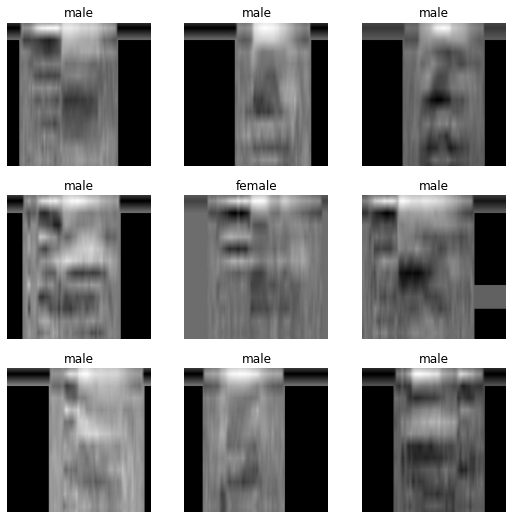

In [21]:
from fastai.vision.all import *

# ... (previous code remains unchanged)

# Use DataBlock and DataLoaders instead of ImageDataBunch
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=RegexLabeller(pat)
)

dls = dblock.dataloaders(path_img, bs=64)

# Show batch and classes
dls.show_batch()
print(dls.vocab)

# You can use dls to train your model with cnn_learner, lr_find, fit_one_cycle, etc.


For more information on batch size selection, see https://forums.fast.ai/t/how-to-check-your-pytorch-keras-is-using-the-gpu/7232/3.

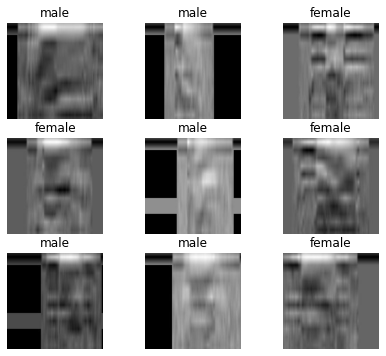

In [26]:
# Replace the old show_batch code with the following
dls.show_batch(nrows=3, ncols=3, figsize=(7,6))


In [31]:
print(dls.vocab)
print(len(dls.vocab), dls.c)


['female', 'male']
2 2


## Train ResNet34

### Transfer learning step 1: only re-train the classifier

Instantiate a learner using data, model and metric:

In [32]:
learn = cnn_learner(dls, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/toandokhanh/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|███████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:11<00:00, 7.93MB/s]


**Note**: Since the model is already trained, you can now directly jump to "Evaluate model" to avoid retraining the model.

Verify the availability of GPU(s):

In [33]:
torch.cuda.is_available()

False

Find a good learning rate: (https://docs.fast.ai/callbacks.lr_finder.html)

SuggestedLRs(valley=0.0014454397605732083)

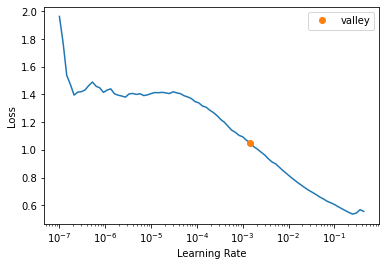

In [34]:
learn.lr_find()

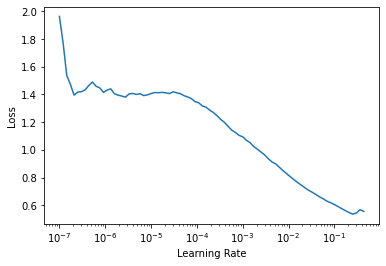

In [36]:
# Plot the learning rate finder graph
learn.recorder.plot_lr_find()

In [37]:
learn.fit_one_cycle(2, 2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.015772,0.007752,0.001667,8:50:38
1,0.006162,0.006405,0.001833,1:12:31


In [39]:
learn.export('model_step1.pkl')

Our model is pretty accurate after only 2 epochs.

### Transfer learning step 2: re-train the entire model

After retraining the classifier, let's also train the convolutional layers.

In [40]:
learn.unfreeze()

In [41]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.008727,0.005069,0.001333,1:39:20


<div style="text-align: justify">
In the context of this dataset, unfreezing and retraining the entire model sometimes do not increase its performance - but sometimes it does. For this reason, I left it here. 
</div>

In [47]:
learn.export('model_step2.pkl')